# 配当利回り

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/J-Quants/jquants-api-client-python/blob/master/examples/20220825-003-dividend.ipynb)


このノートブックでは J-Quants APIから取得できるデータから配当性向、配当利回り、および直近1,3ヶ月のリターンを一覧で表示します。


----

**このノートブックはGoogle Driveを使用します。**

- Google Drive の以下のファイルにリフレッシュトークンが書き込まれていることを想定しています。
    - `MyDrive/drive_ws/secret/jquantsapi-key.txt`
- Google Drive の以下のフォルダーにデータを書き込みます。
    - `MyDrive/drive_ws/marketdata`

In [1]:
# python version　3｡10｡9で動作確認
!python --version

Python 3.10.9


In [2]:
# 必要なモジュールをインストールします。
! python -m pip install jquants-api-client japanize-matplotlib

In [3]:
import os
from datetime import datetime

import japanize_matplotlib
import jquantsapi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

In [5]:
# プロット用の設定をします
sns.set(rc={'figure.figsize': (15, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

japanize_matplotlib.japanize()

In [6]:
# 一度取得したデータは Google Drive 上に保存して再利用します。
# 保存先ディレクトリを指定します。
STORAGE_DIR_PATH = "../drive_ws/marketdata"
os.makedirs(STORAGE_DIR_PATH, exist_ok=True)
STORAGE_DIR_PATH

'../drive_ws/marketdata'

In [7]:
# J-Quants APIのトークンを保存してあるファイルを指定します
REFRESH_TOKEN_FILE_PATH = "../drive_ws/secret/jquantsapi-key.txt"

In [8]:
def get_refresh_token(refresh_token_file_path: str = REFRESH_TOKEN_FILE_PATH):
    with open(refresh_token_file_path, "r") as f:
        refresh_token = f.read()
    return refresh_token.rstrip().lstrip()

In [9]:
# ファイルからリフレッシュトークンを読み込みます
refresh_token = get_refresh_token()


In [10]:
# J-Quants APIクライアントを初期化します
jqapi = jquantsapi.Client(refresh_token=refresh_token)

In [11]:
# 銘柄情報を取得します
## 原罪時間を取り込み
now = pd.Timestamp.now(tz="Asia/Tokyo")
## 時間が22時より前
if now.hour < 22:
    # データ更新時間前の場合は日付を1日ずらします。
    now -= pd.Timedelta(1, unit="D")

list_file = f"{STORAGE_DIR_PATH}/list_{now.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(list_file):
    df_list = jqapi.get_list()
    df_list.to_csv(list_file, compression="gzip", index=False)
    print(f"save file: {list_file}")

# ファイルからデータを読み込みます
print(f"file exists: {list_file}, loading")
df_list = pd.read_csv(list_file, dtype="str")
df_list

file exists: ../drive_ws/marketdata/list_20230129.csv.gz, loading


,Date,Code,CompanyName,Sector17Code,Sector17CodeName,Sector33Code,Sector33CodeName,ScaleCategory,MarketCode,MarketCodeName,Sector17CodeNameEnglish,Sector33CodeNameEnglish,MarketCodeNameEnglish
0,2023-01-30,13010,極洋,1,食品,0050,水産・農林業,TOPIX Small 2,111,プライム,FOODS,"Fishery, Agriculture & Forestry",Prime
1,2023-01-30,13050,ダイワ上場投信−トピックス,99,その他,9999,その他,-,109,その他,OTHER,Other,Others
2,2023-01-30,13060,ＮＥＸＴＦＵＮＤＳＴＯＰＩＸ連動型上場投信,99,その他,9999,その他,-,109,その他,OTHER,Other,Others
3,2023-01-30,13080,上場インデックスファンドＴＯＰＩＸ,99,その他,9999,その他,-,109,その他,OTHER,Other,Others
4,2023-01-30,13090,ＮＥＸＴＦＵＮＤＳＣｈｉｎａＡＭＣ・中国株式・上証５０連動型上場投信,99,その他,9999,その他,-,109,その他,OTHER,Other,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4242,2023-01-30,99930,ヤマザワ,14,小売,6100,小売業,TOPIX Small 2,112,スタンダード,RETAIL TRADE,Retail Trade,Standard
4243,2023-01-30,99940,やまや,14,小売,6100,小売業,TOPIX Small 2,112,スタンダード,RETAIL TRADE,Retail Trade,Standard
4244,2023-01-30,99950,グローセル,13,商社・卸売,6050,卸売業,TOPIX Small 2,111,プライム,COMMERCIAL & WHOLESALE TRADE,Wholesale Trade,Prime
4245,2023-01-30,99960,サトー商会,13,商社・卸売,6050,卸売業,-,112,スタンダード,COMMERCIAL & WHOLESALE TRADE,Wholesale Trade,Standard


##　株価情報の取得

In [12]:
# 株価情報を取得します
now = pd.Timestamp.now(tz="Asia/Tokyo")
# 過去3ヶ月のデータを取得
start_dt = now - pd.Timedelta(95, unit="D")
end_dt = now
if end_dt.hour < 19:
    # データ更新時間前の場合は日付を1日ずらします。
    end_dt -= pd.Timedelta(1, unit="D")
    
price_file = f"{STORAGE_DIR_PATH}/price_{start_dt.strftime('%Y%m%d')}_{end_dt.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(price_file):
    df_p = jqapi.get_price_range(start_dt=start_dt, end_dt=end_dt)
    df_p.to_csv(price_file, compression="gzip", index=False)
    df_p.reset_index(drop=True, inplace=True)
    print(f"save file: {price_file}")

# データを読み込みます
print(f"file exists: {price_file}, loading")
df_p = pd.read_csv(price_file, dtype="str")
df_p.reset_index(drop=True, inplace=True)

# 各列のデータ型を調整します
df_p.loc[:, "Date"] = pd.to_datetime(df_p["Date"], format="%Y-%m-%d")
df_p.loc[:, "Open"] = df_p["Open"].astype(np.float64)
df_p.loc[:, "High"] = df_p["High"].astype(np.float64)
df_p.loc[:, "Low"] = df_p["Low"].astype(np.float64)
df_p.loc[:, "Close"] = df_p["Close"].astype(np.float64)
df_p.loc[:, "Volume"] = df_p["Volume"].astype(np.float64)
df_p.loc[:, "TurnoverValue"] = df_p["TurnoverValue"].astype(np.float64)
df_p.loc[:, "AdjustmentFactor"] = df_p["AdjustmentFactor"].astype(np.float64)
df_p.loc[:, "AdjustmentOpen"] = df_p["AdjustmentOpen"].astype(np.float64)
df_p.loc[:, "AdjustmentHigh"] = df_p["AdjustmentHigh"].astype(np.float64)
df_p.loc[:, "AdjustmentLow"] = df_p["AdjustmentLow"].astype(np.float64)
df_p.loc[:, "AdjustmentClose"] = df_p["AdjustmentClose"].astype(np.float64)
df_p.loc[:, "AdjustmentVolume"] = df_p["AdjustmentVolume"].astype(np.float64)

file exists: ../drive_ws/marketdata/price_20221027_20230129.csv.gz, loading


/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_19392/2407126456.py:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_p.loc[:, "Date"] = pd.to_datetime(df_p["Date"], format="%Y-%m-%d")
/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_19392/2407126456.py:24: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_p.loc[:, "Open"] = df_p["Open"].astype(np.float64)
/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_19392/2407126456.py:25: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt t

## 財務情報の取得

### コード

In [13]:
# 過去3ヶ月に発表された財務情報を取得します

# 取得する日時設定
now = pd.Timestamp.now(tz="Asia/Tokyo")
# start_dt = now - pd.Timedelta(90, unit="D")

# APIとしてサービスが2017年1月1日からなので最古データから受信
start_dt = pd.Timestamp("2017-01-01", tz="Asia/Tokyo")
end_dt = now
if end_dt.hour < 1:
    # データ更新時間前の場合は日付を1日ずらします。
    end_dt -= pd.Timedelta(1, unit="D")

# ファイル名を決める。既に取得したデータがあればそのデータを使う。
statements_file = f"{STORAGE_DIR_PATH}/statements_{start_dt.strftime('%Y%m%d')}_{end_dt.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(statements_file):
    cache_dir = f"{STORAGE_DIR_PATH}/raw_statements"
    os.makedirs(cache_dir, exist_ok=True)
    df_s = jqapi.get_statements_range(
        start_dt=start_dt, end_dt=end_dt, cache_dir=cache_dir
    )
    df_s.to_csv(statements_file, compression="gzip", index=False)
    print(f"save file: {statements_file}")

print(f"file exists: {statements_file}, loading")
df_s = pd.read_csv(statements_file, dtype="str")

# float64にするために"-"をnp.nanに置き換えます
df_s.replace({"－": np.nan}, inplace=True)
df_s["ResultDividendPerShareFiscalYearEnd"] = df_s["ResultDividendPerShareFiscalYearEnd"].astype(np.float64)
df_s["EarningsPerShare"] = df_s["EarningsPerShare"].astype(np.float64)
df_s["ForecastDividendPerShareAnnual"] = df_s["ForecastDividendPerShareAnnual"].astype(np.float64)
df_s["ForecastEarningsPerShare"] = df_s["ForecastEarningsPerShare"].astype(np.float64)

# 日付型に変換します
df_s.loc[:, "DisclosedDate"] = pd.to_datetime(
    df_s["DisclosedDate"], format="%Y-%m-%d"
)
df_s.loc[:, "CurrentPeriodEndDate"] = pd.to_datetime(
    df_s["CurrentPeriodEndDate"], format="%Y-%m-%d"
)
df_s.loc[:, "CurrentFiscalYearStartDate"] = pd.to_datetime(
    df_s["CurrentFiscalYearStartDate"], format="%Y-%m-%d"
)
df_s.loc[:, "CurrentFiscalYearEndDate"] = pd.to_datetime(
    df_s["CurrentFiscalYearEndDate"], format="%Y-%m-%d"
)
df_s.sort_values("DisclosedUnixTime", inplace=True)

file exists: ../drive_ws/marketdata/statements_20170101_20230130.csv.gz, loading


/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_19392/589000079.py:36: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_s.loc[:, "DisclosedDate"] = pd.to_datetime(
/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_19392/589000079.py:39: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_s.loc[:, "CurrentPeriodEndDate"] = pd.to_datetime(
/var/folders/kx/n6w_n8193fn6dy4jwf3fsr6w0000gn/T/ipykernel_19392/589000079.py:42: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace i

In [14]:
df_s

,DisclosureNumber,DisclosedDate,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,AverageNumberOfShares,BookValuePerShare,ChangesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,CurrentFiscalYearEndDate,CurrentFiscalYearStartDate,CurrentPeriodEndDate,DisclosedTime,DisclosedUnixTime,EarningsPerShare,Equity,EquityToAssetRatio,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareAnnual,ForecastDividendPerShareFiscalYearEnd,ForecastEarningsPerShare,ForecastNetSales,ForecastOperatingProfit,ForecastOrdinaryProfit,ForecastProfit,LocalCode,MaterialChangesInSubsidiaries,NetSales,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,OperatingProfit,OrdinaryProfit,Profit,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareAnnual,ResultDividendPerShareFiscalYearEnd,RetrospectiveRestatement,TotalAssets,TypeOfCurrentPeriod,TypeOfDocument
0,20161207453651,2017-01-04,NaN,6848800.0,2671.42,True,False,False,2017-03-31,2016-04-01,2016-12-31,07:30:00,1483482600.0,218.23,18295000000.0,0.817,NaN,NaN,NaN,100.0,50.0,319.76,31800000000,3255000000,3300000000,2190000000,27530,False,22761000000.0,6848800.0,NaN,2147000000.0,2234000000.0,1494000000.0,NaN,50.0,NaN,NaN,NaN,False,22386000000.0,3Q,3QFinancialStatements_Consolidated_JP
1,20161229465838,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-30,2016-07-01,2016-12-31,12:00:00,1483498800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-93.11,110000000,-465000000,-466000000,-467000000,45750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2Q,ForecastRevision
2,20170104467704,2017-01-04,NaN,1916083.0,NaN,True,False,False,2017-02-28,2016-03-01,2016-11-30,15:00:00,1483509600.0,328.57,7566000000.0,0.301,NaN,NaN,NaN,72.0,36.0,485.36,30200000000,1350000000,1300000000,930000000,33530,False,22128000000.0,2035000.0,118917,820000000.0,778000000.0,629000000.0,NaN,36.0,NaN,NaN,NaN,False,25100000000.0,3Q,3QFinancialStatements_Consolidated_JP
3,20170104467943,2017-01-05,NaN,39636693.0,795.65,True,False,False,2017-03-31,2016-04-01,2016-12-31,08:00:00,1483570800.0,75.75,31348000000.0,0.752,NaN,NaN,NaN,26.0,13.0,110.87,21500000000.0,6400000000,6700000000.0,4400000000.0,74630,False,14619000000.0,53812692.0,14413066.0,4018000000.0,4576000000.0,3002000000.0,NaN,13.0,NaN,NaN,NaN,False,41676000000.0,3Q,3QFinancialStatements_Consolidated_JP
4,20170104467675,2017-01-05,False,11260044.0,NaN,True,False,False,2017-02-28,2016-03-01,2016-11-30,15:00:00,1483596000.0,94.10,17678000000.0,0.638,NaN,NaN,NaN,30.0,15.0,133.17,105500000000.0,2650000000,2700000000.0,1500000000.0,99770,NaN,78930000000.0,12500000.0,1223765.0,1786000000.0,1845000000.0,1059000000.0,NaN,15.0,NaN,NaN,NaN,False,27607000000.0,3Q,3QFinancialStatements_NonConsolidated_JP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116051,20230126594189,2023-01-27,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-31,2022-04-01,2023-03-31,17:00:00,1674806400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.14,109000000000,6000000000,5500000000.0,3700000000.0,52880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FY,ForecastRevision
116052,20230126594377,2023-01-27,NaN,13919065.0,NaN,True,False,False,2023-03-31,2022-04-01,2022-12-31,17:00:00,1674806400.0,4.21,8653000000.0,0.657,NaN,NaN,NaN,30.0,25.0,39.38,10900000000,410000000,400000000.0,540000000.0,93770,False,7938000000.0,13950000.0,882135,181000000.0,171000000.0,58000000.0,NaN,5.0,NaN,NaN,NaN,False,13167000000.0,3Q,3QFinancialStatements_Consolidated_JP
116053,20230127595164,2023-01-27,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-31,2022-01-01,2022-12-31,17:00:00,1674806400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56.88,17725000000,1190000000,-1460000000.0,-1648000000.0

### 情報リスト

Disclosure Number ： 開示番号<br>
Disclosed Date ： 開示日<br>
Applying Of SpecificAccounting Of The Quarterly Financial Statements ： 四半期財務諸表の特定会計処理の適用<br>
Average Number Of Shares ： 平均株式数<br>
Book Value PerShare ： 1株当たり簿価<br>
Changes Based On Revisions Of Accounting Standard ： 会計基準の改正に伴う変更<br>
ChangesIn Accounting Estimates ： 会計上の見積りの変更<br>
Changes Other Than Ones Based On Revisions Of Accounting Standard ： 会計基準の改正に基づく変更以外の変更<br>
Current Fiscal Year End Date ： 現在の会計年度末日<br>
Current Fiscal Year Start Date ： 当会計年度開始日<br>
Current Period End Date ： 当期終了日<br>
Disclosed Time ： 開示時間<br>
Disclosed Unix Time ： 開示された Unix 時間<br>
Earnings Per Share ： 一株当たり利益<br>
Equity ： 株式<br>
Equity To AssetRatio ： 自己資本比率<br>
Forecast Dividend Per Share 1st Quarter ： 1株当たり配当予想 第1四半期<br>
Forecast Dividend Per Share 2nd Quarter ： 第2四半期の1株当たり配当予想<br>
Forecast Dividend Per Share 3rd Quarter ： 1株当たり配当予想 第3四半期<br>
Forecast Dividend Per Share Annual ： 年間1株当たり配当予想<br>
Forecast Dividend Per Share Fiscal Year End ： 1株当たり配当予想 期末<br>
Forecast Earnings Per Share ： 1株当たり利益予想<br>
Forecast Net Sales ： 予想売上高<br>
Forecast Operating Profit ： 予想営業利益<br>
Forecast Ordinary Profit ： 経常利益予想<br>
Forecast Profit ： 予想利益<br>
Local Code ： ローカル コード<br>
Material ChangesIn Subsidiaries ： 子会社における重要な変更<br>
NetSales ： 純売上高<br>
Number Of Issued And Outstanding Shares At The End Of Fiscal YearIncluding Treasury Stock ： 期末発行済株式数自己株式を含む<br>
Number Of Treasury Stock At The End Of FiscalYear ： 期末自己株式数<br>
Operating Profit ： 営業利益<br>
Ordinary Profit ： 経常利益<br>
Profit ： 利益<br>
Result Dividend Per Share 1st Quarter ： 第1四半期の1株当たり配当金の結果<br>
Result Dividend Per Share 2nd Quarter ： 第2四半期の1株当たり配当金の結果<br>
Result Dividend Per Share 3rd Quarter ： 第3四半期の1株当たり配当金の結果<br>
Result Dividend Per Share Annual ： 結果 1株当たり配当金 年間<br>
Result Dividend PerShare Fiscal Year End ： 結果 1株当たり配当金 年度末<br>
Retrospective Restatement ： 遡及的修正<br>
Total Assets ： 総資産<br>
Type Of CurrentPeriod ： 現在の期間の種類<br>
Type Of Document ： 書類の種類<br>

## 株価データを作業ワークへ
財務情報　：　df_work = df_s.copy()
株価情報　：　df_p_work = df_p.copy()

In [15]:
# 作業用にデータをコピーします
df_work = df_s.copy()
df_p_work = df_p.copy()

## 前処理

In [16]:
# 財務情報を銘柄ごとに重複を排除して最新の財務情報のみを使用します
df_work.sort_values("DisclosedUnixTime", inplace=True)
df_work = df_work.drop_duplicates(["LocalCode"], keep="last")

# 終値が0の場合は前営業日の終値を使用します
df_p_work.sort_values(["Code", "Date"], inplace=True)
df_p_work["AdjustmentClose"].replace({0.0: np.nan}, inplace=True)
df_p_work.loc[:, "AdjustmentClose"] = df_p_work.groupby("Code")["AdjustmentClose"].ffill()
# 終値がnanの場合は翌営業日の終値を使用します (データの先頭)
df_p_work.loc[:, "AdjustmentClose"] = df_p_work.groupby("Code")["AdjustmentClose"].bfill()
# 各銘柄の直近のリターンを算出します
def _calc_return(df, bdays):
  return (df["AdjustmentClose"].iat[-1] / df["AdjustmentClose"].iloc[-bdays:].iat[0]) - 1
df_p_work.sort_values(["Code", "Date"], inplace=True)
df_returns_1months = df_p_work.groupby("Code").apply(_calc_return, 20).rename("1ヶ月リターン")
df_returns_3months = df_p_work.groupby("Code").apply(_calc_return, 60).rename("3ヶ月リターン")
# リターンと結合します
df_work = pd.merge(df_work, df_returns_1months, left_on=["LocalCode"], right_index=True, how="left")
df_work = pd.merge(df_work, df_returns_3months, left_on=["LocalCode"], right_index=True, how="left")

# 配当利回りを計算するために直近の終値を取得します
df_close = df_p_work.loc[df_p_work["Date"] == df_p_work["Date"].max(), ["Code", "Date", "AdjustmentClose"]]
# 直近の株価と結合します
df_work = pd.merge(df_work, df_close, left_on=["LocalCode"], right_on=["Code"], how="left")
# 配当利回りを算出します
df_work["配当利回り"] = df_work["ResultDividendPerShareFiscalYearEnd"] / df_work["AdjustmentClose"]
# 予想配当利回りを算出します
df_work["予想配当利回り"] = df_work["ForecastDividendPerShareAnnual"] / df_work["AdjustmentClose"]

# 配当性向を算出します
df_work["配当性向"] = df_work["ResultDividendPerShareFiscalYearEnd"] / df_work["EarningsPerShare"] 
# 予想配当性向を算出します
df_work["予想配当性向"] = df_work["ForecastDividendPerShareAnnual"] / df_work["ForecastEarningsPerShare"]

# 銘柄名と結合します
df_work = pd.merge(df_work, df_list, left_on=["LocalCode"], right_on=["Code"])

# 表示用に開示日を追加します
df_work["開示日"] = df_work["DisclosedDate"].dt.strftime("%Y-%m-%d")

In [17]:
# 表示する項目を指定します
output_cols = [
    "LocalCode",
    "CompanyName",
    "開示日",
    "配当性向",
    "予想配当性向",
    "配当利回り",
    "予想配当利回り",
    "1ヶ月リターン",
    "3ヶ月リターン",
]
# 項目別に表示方法を指定します
output_format = {
    "配当性向": "{:.2%}",
    "予想配当性向": "{:.2%}",
    "配当利回り": "{:.2%}",
    "予想配当利回り": "{:.2%}",
    "1ヶ月リターン": "{:.2%}",
    "3ヶ月リターン": "{:.2%}",
}

## データの表示

In [18]:
# 配当利回り順に上位20銘柄を表示します
df_work.sort_values(["配当利回り"], ascending=False)[output_cols].head(20).style.format(output_format)

,LocalCode,CompanyName,開示日,配当性向,予想配当性向,配当利回り,予想配当利回り,1ヶ月リターン,3ヶ月リターン
2956,34750,グッドコムアセット,2022-12-12,60.25%,30.70%,7.52%,4.39%,-2.09%,13.84%
2004,17430,コーアツ工業,2022-11-11,30.37%,23.43%,6.98%,2.33%,5.50%,-10.42%
2636,66770,エスケーエレクトロニクス,2022-11-14,20.16%,20.16%,5.42%,2.79%,8.25%,-5.97%
3785,88920,日本エスコン,2023-01-27,49.97%,38.51%,4.82%,4.82%,-2.23%,-2.71%
488,71480,ＦＰＧ,2022-10-31,50.38%,50.34%,4.78%,5.35%,-4.82%,-9.98%
2567,29610,日本調理機,2022-11-14,64.64%,36.17%,4.73%,3.94%,-1.32%,4.88%
2787,92480,人・夢・技術グループ,2022-11-14,25.20%,29.69%,4.47%,2.71%,-15.95%,-45.51%
2930,72650,エイケン工業,2022-12-09,40.30%,42.95%,4.31%,4.31%,3.78%,-5.94%
2342,88890,ＡＰＡＭＡＮ,2022-11-11,136.15%,119.19%,4.27%,4.27%,2.41%,-2.09%
2265,94460,サカイホールディングス,2022-11-11,47.95%,51.38%,4.27%,4.64%,0.19%,-0.19%


In [19]:
# 予想配当利回り順に上位20銘柄を表示します
df_work.sort_values(["予想配当利回り"], ascending=False)[output_cols].head(20).style.format(output_format)

,LocalCode,CompanyName,開示日,配当性向,予想配当性向,配当利回り,予想配当利回り,1ヶ月リターン,3ヶ月リターン
246,91040,商船三井,2022-10-31,nan%,25.14%,nan%,17.38%,-5.24%,7.25%
293,91100,ＮＳユナイテッド海運,2022-10-31,nan%,30.82%,nan%,8.94%,-2.44%,2.84%
1944,93080,乾汽船,2022-11-11,nan%,46.58%,nan%,8.80%,0.00%,3.31%
2296,15180,三井松島ホールディングス,2022-11-11,nan%,19.50%,nan%,8.39%,6.80%,34.22%
642,18200,西松建設,2022-11-04,nan%,83.33%,nan%,7.03%,2.92%,12.02%
361,29140,日本たばこ産業,2022-10-31,nan%,74.98%,nan%,7.03%,-5.89%,8.58%
1475,16620,石油資源開発,2022-11-10,nan%,30.85%,nan%,7.00%,10.15%,11.01%
1795,45950,ミズホメディー,2022-11-11,nan%,30.17%,nan%,6.76%,-17.59%,3.99%
223,53340,日本特殊陶業,2022-10-28,nan%,39.71%,nan%,6.54%,3.29%,-6.27%
1008,51920,三ツ星ベルト,2022-11-08,nan%,100.19%,nan%,6.53%,6.37%,16.11%


'1ヶ月リターン'

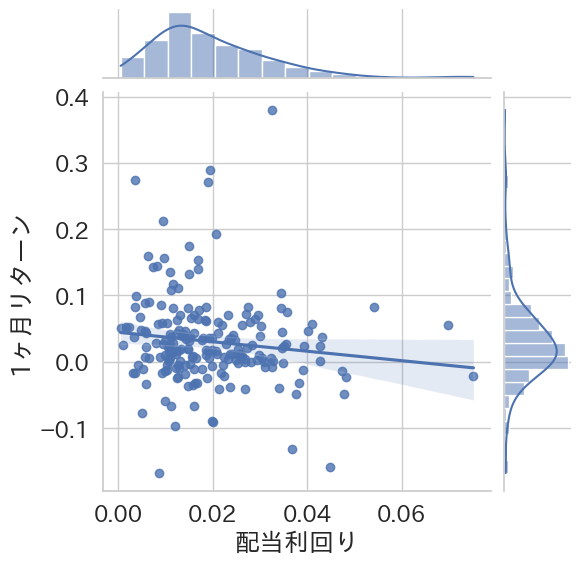

'３ヶ月リターン'

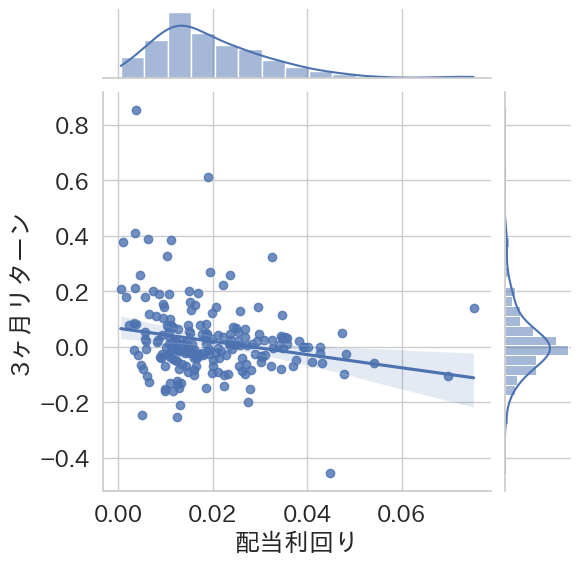

In [20]:
# 横軸に配当利回り、縦軸に1,3ヶ月リターンとして関係性をプロットします
display("1ヶ月リターン")
sns.jointplot(x='配当利回り', y='1ヶ月リターン', data=df_work.loc[df_work["配当利回り"] > 0.00], kind="reg")
plt.show()

display("３ヶ月リターン")
sns.jointplot(x='配当利回り', y='3ヶ月リターン', data=df_work.loc[df_work["配当利回り"] > 0.00], kind="reg")
plt.show()

'1ヶ月リターン'

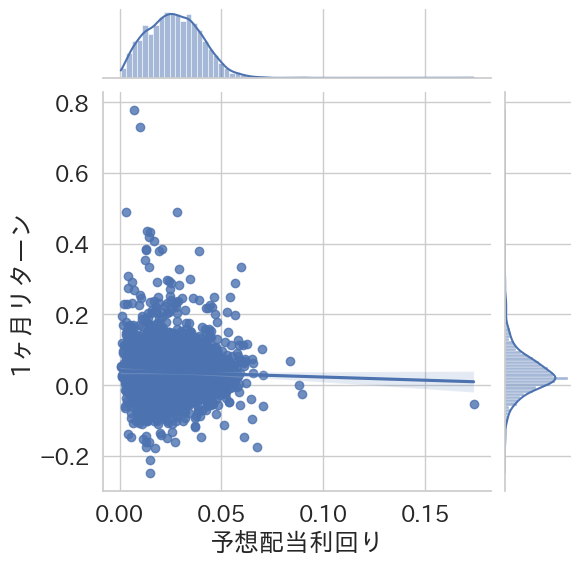

'３ヶ月リターン'

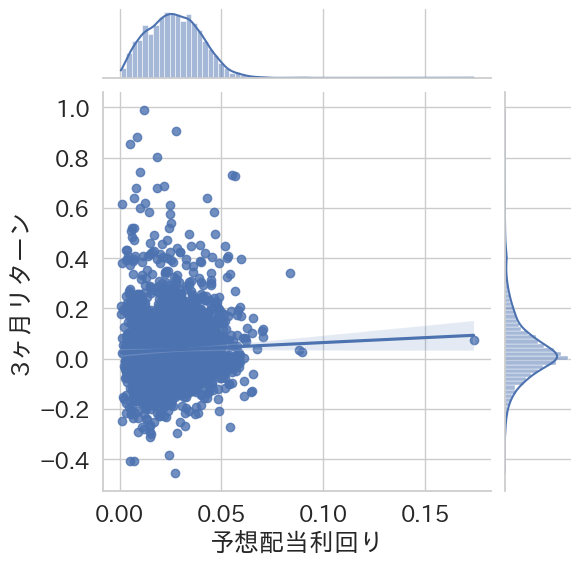

In [21]:
# 横軸に予想配当利回り、縦軸に1,3,6ヶ月リターンとして関係性をプロットします
display("1ヶ月リターン")
sns.jointplot(x='予想配当利回り', y='1ヶ月リターン', data=df_work.loc[df_work["予想配当利回り"] > 0.00], kind="reg")
plt.show()

display("３ヶ月リターン")
sns.jointplot(x='予想配当利回り', y='3ヶ月リターン', data=df_work.loc[df_work["予想配当利回り"] > 0.00], kind="reg")
plt.show()

'1ヶ月リターン'

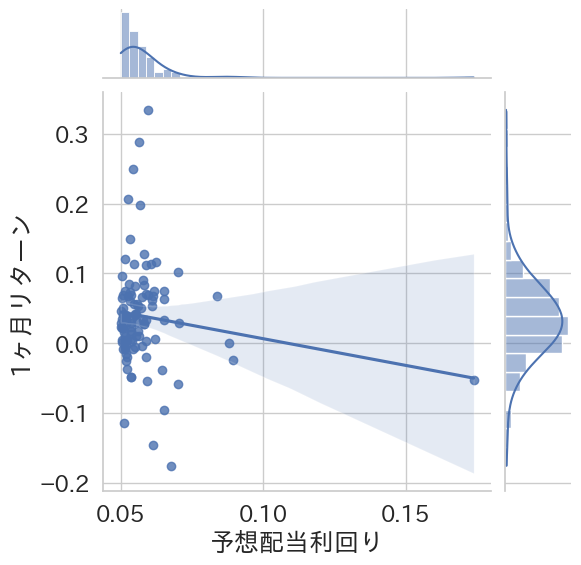

'３ヶ月リターン'

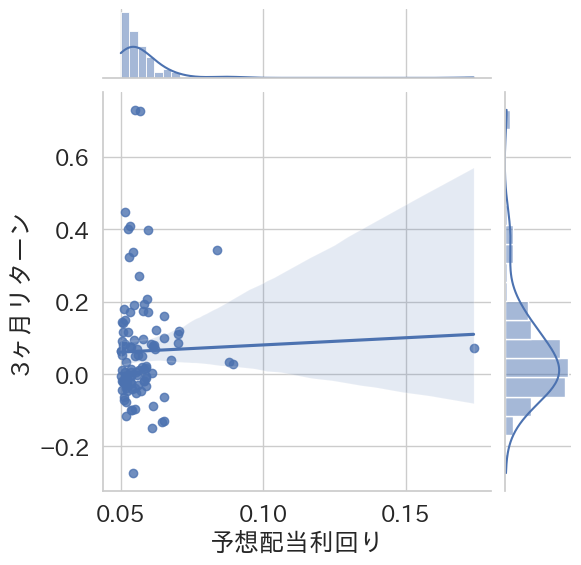

In [22]:
# 予想配当利回りが5%以上の銘柄とリターンの関係性をプロットします
display("1ヶ月リターン")
sns.jointplot(x='予想配当利回り', y='1ヶ月リターン', data=df_work.loc[df_work["予想配当利回り"] >= 0.05], kind="reg")
plt.show()

display("３ヶ月リターン")
sns.jointplot(x='予想配当利回り', y='3ヶ月リターン', data=df_work.loc[df_work["予想配当利回り"] >= 0.05], kind="reg")
plt.show()

## 遊びデータ

In [23]:
# 作業用にデータをコピーします
df_work

,DisclosureNumber,DisclosedDate,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,AverageNumberOfShares,BookValuePerShare,ChangesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,CurrentFiscalYearEndDate,CurrentFiscalYearStartDate,CurrentPeriodEndDate,DisclosedTime,DisclosedUnixTime,EarningsPerShare,Equity,EquityToAssetRatio,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareAnnual,ForecastDividendPerShareFiscalYearEnd,ForecastEarningsPerShare,ForecastNetSales,ForecastOperatingProfit,ForecastOrdinaryProfit,ForecastProfit,LocalCode,MaterialChangesInSubsidiaries,NetSales,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,OperatingProfit,OrdinaryProfit,Profit,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareAnnual,ResultDividendPerShareFiscalYearEnd,RetrospectiveRestatement,TotalAssets,TypeOfCurrentPeriod,TypeOfDocument,1ヶ月リターン,3ヶ月リターン,Code_x,Date_x,AdjustmentClose,配当利回り,予想配当利回り,配当性向,予想配当性向,Date_y,Code_y,CompanyName,Sector17Code,Sector17CodeName,Sector33Code,Sector33CodeName,ScaleCategory,MarketCode,MarketCodeName,Sector17CodeNameEnglish,Sector33CodeNameEnglish,MarketCodeNameEnglish,開示日
0,20210728472790,2021-07-28,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-30,2020-10-01,2021-09-30,16:00:00,1627455600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2776.00,3425000000.0,1459000000.0,1074000000.0,1073000000.0,92840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FY,ForecastRevision_REIT,-0.039185,-0.039185,92840,2023-01-27,122600.0,NaN,NaN,NaN,NaN,2023-01-30,92840,カナディアン・ソーラー・インフラ投資法人,99,その他,9999,その他,-,109,その他,OTHER,Other,Others,2021-07-28
1,20220814520026,2022-08-15,NaN,NaN,133118.0,False,False,False,2022-06-30,2022-01-01,2022-06-30,15:00:00,1660543200.0,3236.00,75172000000.0,0.533,NaN,NaN,NaN,NaN,NaN,NaN,5718000000,3772000000,3494000000,3493000000,34870,NaN,3871000000.0,564700.0,0,2119000000.0,1828000000.0,1827000000.0,NaN,NaN,NaN,NaN,NaN,False,140960000000.0,FY,FYFinancialStatements_REIT,-0.077635,-0.123167,34870,2023-01-27,179400.0,NaN,NaN,NaN,NaN,2023-01-30,34870,ＣＲＥロジスティクスファンド投資法人,99,その他,9999,その他,-,109,その他,OTHER,Other,Others,2022-08-15
2,20220815520385,2022-08-15,NaN,NaN,416906.0,False,False,False,2022-06-30,2022-01-01,2022-06-30,15:00:00,1660543200.0,14998.00,709154000000.0,0.518,NaN,NaN,NaN,NaN,NaN,NaN,47326000000,21442000000,20071000000,20071000000,89510,NaN,52215000000.0,1700991.0,0,26806000000.0,25440000000.0,25439000000.0,NaN,NaN,NaN,NaN,NaN,False,1367719000000.0,FY,FYFinancialStatements_REIT,-0.046205,-0.125567,89510,2023-01-27,578000.0,NaN,NaN,NaN,NaN,2023-01-30,89510,日本ビルファンド投資法人,99,その他,9999,その他,-,109,その他,OTHER,Other,Others,2022-08-15
3,20220816520742,2022-08-16,NaN,NaN,290249.0,False,False,False,2022-06-30,2022-01-01,2022-06-30,15:00:00,1660629600.0,8825.00,130592000000,0.475,NaN,NaN,NaN,NaN,NaN,NaN,8434000000,4392000000,3716000000,3716000000,32960,NaN,8534000000,449930,0,4599000000,3971000000,3970000000,NaN,NaN,NaN,NaN,NaN,False,274895000000,FY,FYFinancialStatements_REIT,-0.054852,-0.084469,32960,2023-01-27,336000.0,NaN,NaN,NaN,NaN,2023-01-30,32960,日本リート投資法人,99,その他,9999,その他,-,109,その他,OTHER,Other,Others,2022-08-16
4,20220816520802,2022-08-16,NaN,NaN,273684.0,False,False,False,2022-06-30,2022-01-01,2022-06-30,15:00:00,1660629600.0,8664.00,272912000000,0.538,NaN,NaN,NaN,NaN,NaN,NaN,18472000000,9393000000,8579000000,8578000000,89550,NaN,18357000000,997178,0,9343000000,8607000000,8607000000,NaN,NaN,NaN,NaN,NaN,False,507005000000,FY,FYFinancialStatements_REIT,-0.043593,-0.102850,89550,2023-01-27,362000.0,NaN,NaN,NaN,NaN,2023-01-30,89550,日本プライムリアルティ投資法人,99,その他,9999,その他,-,109,その他,OTHER,Other,Others,2022-08-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [24]:
df_p_work

,Code,Date,Open,High,Low,Close,Volume,TurnoverValue,AdjustmentFactor,AdjustmentOpen,AdjustmentHigh,AdjustmentLow,AdjustmentClose,AdjustmentVolume
0,13010,2022-10-27,3630.0,3630.0,3580.0,3595.0,8000.0,28784000.0,1.0,3630.0,3630.0,3580.0,3595.0,8000.0
1,13010,2022-10-28,3565.0,3660.0,3565.0,3610.0,63900.0,231068500.0,1.0,3565.0,3660.0,3565.0,3610.0,63900.0
2,13010,2022-10-31,3620.0,3635.0,3590.0,3615.0,11300.0,40794500.0,1.0,3620.0,3635.0,3590.0,3615.0,11300.0
3,13010,2022-11-01,3650.0,3660.0,3635.0,3660.0,4900.0,17894500.0,1.0,3650.0,3660.0,3635.0,3660.0,4900.0
4,13010,2022-11-02,3665.0,3740.0,3630.0,3645.0,47300.0,173511500.0,1.0,3665.0,3740.0,3630.0,3645.0,47300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262437,99970,2023-01-23,680.0,685.0,679.0,683.0,96000.0,65525700.0,1.0,680.0,685.0,679.0,683.0,96000.0
262438,99970,2023-01-24,688.0,688.0,680.0,682.0,140700.0,96201000.0,1.0,688.0,688.0,680.0,682.0,140700.0
262439,99970,2023-01-25,682.0,686.0,680.0,684.0,68900.0,47110100.0,1.0,682.0,686.0,680.0,684.0,68900.0
262440,99970,2023-01-26,687.0,697.0,686.0,697.0,117100.0,81164900.0,1.0,687.0,697.0,686.0,697.0,117100.0
